# Imports

In [294]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy.stats
from mycolorpy import colorlist as mcp
import matplotlib
import geopandas as gpd
import jenkspy
import os
from datetime import datetime

# Define country and parameters

In [ ]:
# Select target country
country = 'Colombia'

# Set country-specific parameters: ISO codes and buffer size (in meters)
if country == 'Argentina':
    country_short = 'ARG'   # ISO 3-letter code
    country_code = 'AR'     # ISO 2-letter code
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'
# Uncomment the following if Mexico is to be included in the analysis
# elif country == 'Mexico':
#     country_short = 'MEX'
#     country_code = 'MX'

# Set working directory

In [1]:
# Define working directory path
wd = (
    '/your/path/to/working/directory/'
)

# Load data

In [563]:
baseline_pop_imput = gpd.read_file(
    wd
    + '/data/outputs/'
    + country_short
    + '/grids-with-data/movcell-baseline-imput-pop-with-exo-var/'
    + 'movcell-baseline-imput-pop-with-exo-var.gpkg'
)

In [564]:
# Number of density classes to create
n_class_density = 5

# Calculate Jenks natural breaks for density values (excluding NaNs)
breaks_density = jenkspy.jenks_breaks(
    baseline_pop_imput.dropna(subset=['density'])['density'], 
    n_classes=n_class_density
)

# Slightly adjust the lowest break point to include the minimum value
breaks_density[0] = breaks_density[0] - 1e-10

# Classify density into bins based on Jenks breaks and assign labels 0 to n_class_density-1
baseline_pop_imput['class_density'] = pd.cut(
    baseline_pop_imput['density'], 
    bins=breaks_density, 
    labels=[i for i in range(n_class_density)]
)

# Convert class labels to numeric type
baseline_pop_imput['class_density'] = pd.to_numeric(baseline_pop_imput['class_density'])

# Number of RDI classes to create
n_class_rdi = 3

# Calculate Jenks natural breaks for rdi values (excluding NaNs)
breaks_rdi = jenkspy.jenks_breaks(
    baseline_pop_imput.dropna(subset=['rdi'])['rdi'], 
    n_classes=n_class_rdi
)

# Slightly adjust the lowest break point to include the minimum value
breaks_rdi[0] = breaks_rdi[0] - 1e-10

# Classify rdi into bins based on Jenks breaks and assign labels 0 to n_class_rdi-1
baseline_pop_imput['class_rdi'] = pd.cut(
    baseline_pop_imput['rdi'], 
    bins=breaks_rdi, 
    labels=[i for i in range(n_class_rdi)]
)

# Convert class labels to numeric type
baseline_pop_imput['class_rdi'] = pd.to_numeric(baseline_pop_imput['class_rdi'])

In [566]:
# Create a DataFrame with relevant columns from baseline_pop_imput
df = pd.DataFrame({
    'density': baseline_pop_imput['class_density'],
    'rdi': baseline_pop_imput['class_rdi'],
    'population': baseline_pop_imput['population']
})

# Drop rows with missing values and reset the index
df = df.dropna().reset_index(drop=True)

# Initialize arrays to hold counts and population sums for each density-RDI class combination
counts = np.zeros((len(np.unique(df['density'])), len(np.unique(df['rdi']))))
population = np.zeros((len(np.unique(df['density'])), len(np.unique(df['rdi']))))

# Loop through rows to populate counts and population arrays
for i in range(len(df)):
    j = int(df.loc[i, 'density'])
    k = int(df.loc[i, 'rdi'])
    counts[j, k] += 1
    population[j, k] += df.loc[i, 'population']

# Compute Pearson correlation between density and RDI classes
res = scipy.stats.pearsonr(df['density'], df['rdi'])
print(res.statistic, res.pvalue)

# Compute Spearman correlation between density and RDI classes
res = scipy.stats.spearmanr(df['density'], df['rdi'])
print(res.statistic, res.pvalue)

# Print counts matrix
print(counts)

# Print population matrix
print(population)

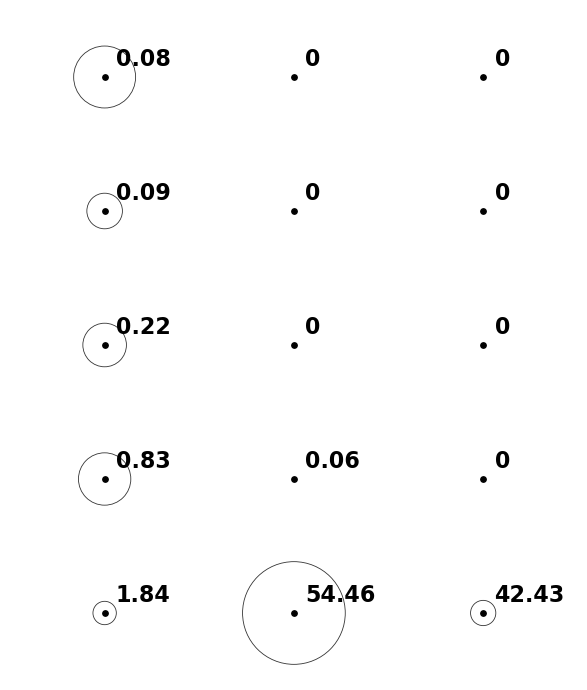

In [573]:
# Scale population values to determine marker sizes
sizes = (population / np.max(population) * 50) ** 2.2  # Scale to a max size ~1000

# Create a meshgrid for the x (RDI classes) and y (density classes) positions
x, y = np.meshgrid(np.arange(counts.shape[1]), np.arange(counts.shape[0]))

# Flatten the grids for scatter plotting
x_flat = x.flatten()
y_flat = y.flatten()
color_vals = counts.flatten()
size_vals = sizes.flatten()
count_vals = counts.flatten()

# Create the plot
fig, ax = plt.subplots(figsize=(6, 7))

# Outer circles representing population (size only, transparent fill)
sc = plt.scatter(
    x_flat, y_flat,
    s=size_vals,
    color="None",             # No fill color
    edgecolors='k',           # Black edge
    linewidth=0.6,
    alpha=0.8,
    zorder=3
)

# Inner black dots to mark center of each circle
plt.scatter(
    x_flat, y_flat,
    s=15,
    color="black",
    edgecolors='k',
    linewidth=1,
    alpha=1,
    zorder=4
)

# Annotate each circle with the percent of total count
for i in range(len(x_flat)):
    percent = count_vals[i] / np.sum(count_vals) * 100
    label = (
        str(int(percent)) if count_vals[i] == 0
        else str(round(percent, 2))
    )
    ax.text(
        x_flat[i] + 0.06,
        y_flat[i] + 0.22,
        label,
        ha='left',
        va='top',
        fontsize=16,
        fontweight='bold'
    )

# Set axis limits
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([-0.5, 4.5])

# Remove axis lines and labels for a cleaner look
plt.axis('off')

# Adjust layout
plt.tight_layout()

# Save the figure to file
plt.savefig(
    wd + '/plots/classes/' + country_short + '/tiles_popualtions_vertical.pdf',
    bbox_inches='tight',
    transparent=True
)

# Show the plot
plt.show()

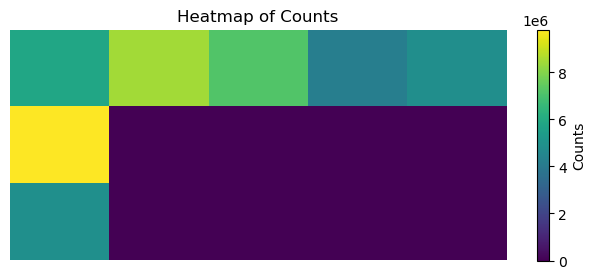

In [254]:
# Create heatmap
plt.figure(figsize=(8, 3))
plt.imshow(population, cmap='viridis', aspect='auto')

# Add colorbar
plt.colorbar(label='Counts')

# Hide axis labels
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.title("Heatmap of Counts")
plt.show()